### Import libraries

In [89]:
import os
import numpy as np
import pandas as pd
import glob as gb
import cv2
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from tensorflow import keras
from keras import layers
from keras import models
from keras import Input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
train_dataset_path = r"D:\Project\PG Project\Data\Image Data\seg_train"

test_dataset_path = r"D:\Project\PG Project\Data\Image Data\seg_test"

predict_dataset_path = r"D:\Project\PG Project\Data\Image Data\seg_pred\seg_pred"

### Checking data information

In [5]:
train_dataset_checking_path = os.path.join(train_dataset_path, 'seg_train')

for folder in os.listdir(train_dataset_checking_path):
    folder_path = os.path.join(train_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    print(f"For training data, found {len(files)} images in folder {folder}")
print()

test_dataset_checking_path = os.path.join(test_dataset_path, 'seg_test')

for folder in os.listdir(test_dataset_checking_path):
    folder_path = os.path.join(test_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    print(f"For testing data, found {len(files)} images in folder {folder}")
print()

files = gb.glob(os.path.join(predict_dataset_path, '*.jpg'))
print(f"For predicting data, found {len(files)} images")

For training data, found 2190 images in folder buildings
For training data, found 2263 images in folder forest
For training data, found 2387 images in folder glacier
For training data, found 2495 images in folder mountain
For training data, found 2270 images in folder sea
For training data, found 2381 images in folder street

For testing data, found 437 images in folder buildings
For testing data, found 473 images in folder forest
For testing data, found 549 images in folder glacier
For testing data, found 523 images in folder mountain
For testing data, found 510 images in folder sea
For testing data, found 501 images in folder street

For predicting data, found 7288 images


In [6]:
size = []
for folder in os.listdir(train_dataset_checking_path):
    folder_path = os.path.join(train_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
print(' Image size\t Count')
pd.Series(size).value_counts()

 Image size	 Count


(150, 150, 3)    13986
Name: count, dtype: int64

In [7]:
size = []
for folder in os.listdir(test_dataset_checking_path):
    folder_path = os.path.join(test_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
print(' Image size\t Count')
pd.Series(size).value_counts()

 Image size	 Count


(150, 150, 3)    2993
Name: count, dtype: int64

In [8]:
size = []
files = gb.glob(os.path.join(predict_dataset_path, '*.jpg'))
for file in files: 
    image = plt.imread(file)
    size.append(image.shape)
print(' Image size\t Count')
pd.Series(size).value_counts()

 Image size	 Count


(150, 150, 3)    7288
Name: count, dtype: int64

### Retain (150,150,3)-sized images

In [10]:
Removed_image_dir = os.path.join(r'D:\项目\Comp702\Data\Image Data', 'Removed_train_images')
os.makedirs(Removed_image_dir, exist_ok=True)

moved_count1 = 0
moved_count2 = 0
moved_count3 = 0

for folder in os.listdir(train_dataset_checking_path):
    folder_path = os.path.join(train_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files:
        with Image.open(file) as img:
            img = img.convert('RGB')  # 转换为 RGB
            if img.size != (150, 150):
                # 构建新文件名，包含类别前缀
                new_name = f"{folder}_{os.path.basename(file)}"
                shutil.move(file, os.path.join(Removed_image_dir, new_name))
                moved_count1 += 1



for folder in os.listdir(test_dataset_checking_path):
    folder_path = os.path.join(test_dataset_checking_path, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for file in files:
        with Image.open(file) as img:
            img = img.convert('RGB')  # 转换为 RGB
            if img.size != (150, 150):
                # 构建新文件名，包含类别前缀
                new_name = f"{folder}_{os.path.basename(file)}"
                shutil.move(file, os.path.join(Removed_image_dir, new_name))
                moved_count2 += 1


files = gb.glob(os.path.join(predict_dataset_path, '*.jpg'))
for file in files:
        with Image.open(file) as img:
            img = img.convert('RGB')  # 转换为 RGB
            if img.size != (150, 150):
                # 构建新文件名，包含类别前缀
                new_name = f"{folder}_{os.path.basename(file)}"
                shutil.move(file, os.path.join(Removed_image_dir, new_name))
                moved_count3 += 1

print(f"moving {moved_count1} train_images to {Removed_image_dir}")
print(f"moving {moved_count2} test_images to {Removed_image_dir}")
print(f"moving {moved_count3} predict_images to {Removed_image_dir}")

moving 0 train_images to D:\项目\Comp702\Data\Image Data\Removed_train_images
moving 0 test_images to D:\项目\Comp702\Data\Image Data\Removed_train_images
moving 0 predict_images to D:\项目\Comp702\Data\Image Data\Removed_train_images


### Label mapping

In [53]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


### Data loading

In [56]:
train_dir = r"D:\Project\PG Project\Data\Image Data\seg_train\seg_train"
test_dir = r"D:\Project\PG Project\Data\Image Data\seg_test\seg_test"

def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [58]:
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading D:\Project\PG Project\Data\Image Data\seg_train\seg_train


100%|██████████| 2381/2381 [00:01<00:00, 1606.24it/s]


Images file have been loaded
loading D:\Project\PG Project\Data\Image Data\seg_test\seg_test


100%|██████████| 501/501 [00:00<00:00, 1625.98it/s]


Images file have been loaded


In [60]:
print("train dataset size",len(train_images), len(train_labels))
print("test dataset size",len(test_images), len(test_labels))

train dataset size 13986 13986
test dataset size 2993 2993


### Model building

In [63]:
model = models.Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,334 (466.15 KB)

 Trainable params: 119,334 (466.15 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
print(train_labels.shape)
print(train_labels[:5])

(13986,)
[0 0 0 0 0]


### Normalisation

In [68]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

### For recording training time

In [71]:
class EpochTimeLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = (time.time() - self.epoch_start) * 1000  # 毫秒
        self.epoch_times.append(duration)

### First training

In [74]:
# convert labels to categorical 
train_labels = to_categorical(train_labels, num_classes=6)  # shape → (N, 6)
test_labels = to_categorical(test_labels, num_classes=6)

# compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

checkpointer = ModelCheckpoint(filepath='bestvalue.keras', verbose=0, save_best_only=True)

time_logger = EpochTimeLogger()

callback_list = [checkpointer, earlystopping, time_logger]

# fit model to the data
history = model.fit(train_images_norm, train_labels, batch_size=128, epochs=15, validation_data=(test_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(test_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.3910 - loss: 1.4504 - val_accuracy: 0.5830 - val_loss: 1.0770
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - accuracy: 0.5936 - loss: 1.0342 - val_accuracy: 0.6619 - val_loss: 0.9110
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.6745 - loss: 0.8668 - val_accuracy: 0.6953 - val_loss: 0.7975
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 339ms/step - accuracy: 0.7153 - loss: 0.7604 - val_accuracy: 0.7304 - val_loss: 0.7088
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - accuracy: 0.7405 - loss: 0.6937 - val_accuracy: 0.7594 - val_loss: 0.6660
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 335ms/step - accuracy: 0.7716 - loss: 0.6266 - val_accuracy: 0.7902 - val_loss: 0.5915
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 328ms/step - accuracy: 0.7875 - loss: 0.5858 - val_accuracy: 0.7878 - val_loss: 0.6065
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.7936 - loss: 0

### Training time

In [76]:
for i, t in enumerate(time_logger.epoch_times):
    print(f"Epoch {i+1} duration: {t:.2f} ms")

Epoch 1 duration: 40725.36 ms
Epoch 2 duration: 37468.48 ms
Epoch 3 duration: 37672.21 ms
Epoch 4 duration: 37342.05 ms
Epoch 5 duration: 37625.67 ms
Epoch 6 duration: 36965.00 ms
Epoch 7 duration: 36178.33 ms
Epoch 8 duration: 36626.62 ms
Epoch 9 duration: 37462.68 ms
Epoch 10 duration: 37780.09 ms
Epoch 11 duration: 37560.81 ms
Epoch 12 duration: 37275.63 ms
Epoch 13 duration: 36907.53 ms
Epoch 14 duration: 37147.58 ms
Epoch 15 duration: 37687.86 ms


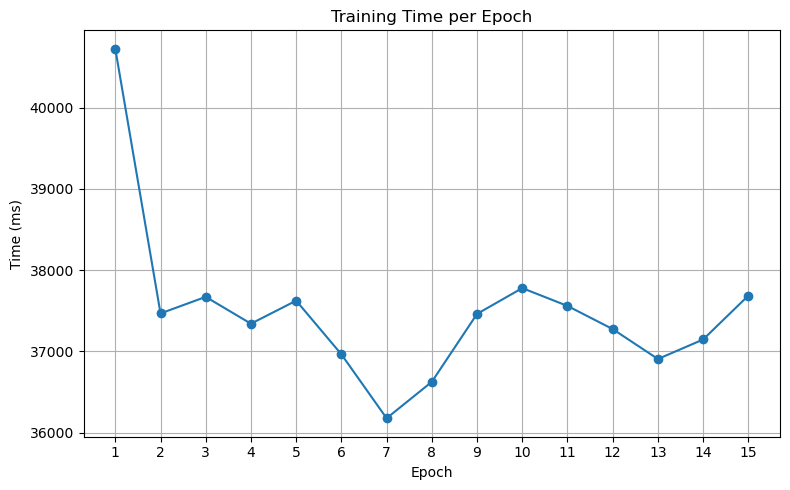

In [78]:
epoch_times = time_logger.epoch_times
epoch_numbers = np.arange(1, len(epoch_times) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epoch_numbers, epoch_times, marker='o')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (ms)")
plt.grid(True)
plt.xticks(epoch_numbers)
plt.tight_layout()
plt.show()

### Model accuracy

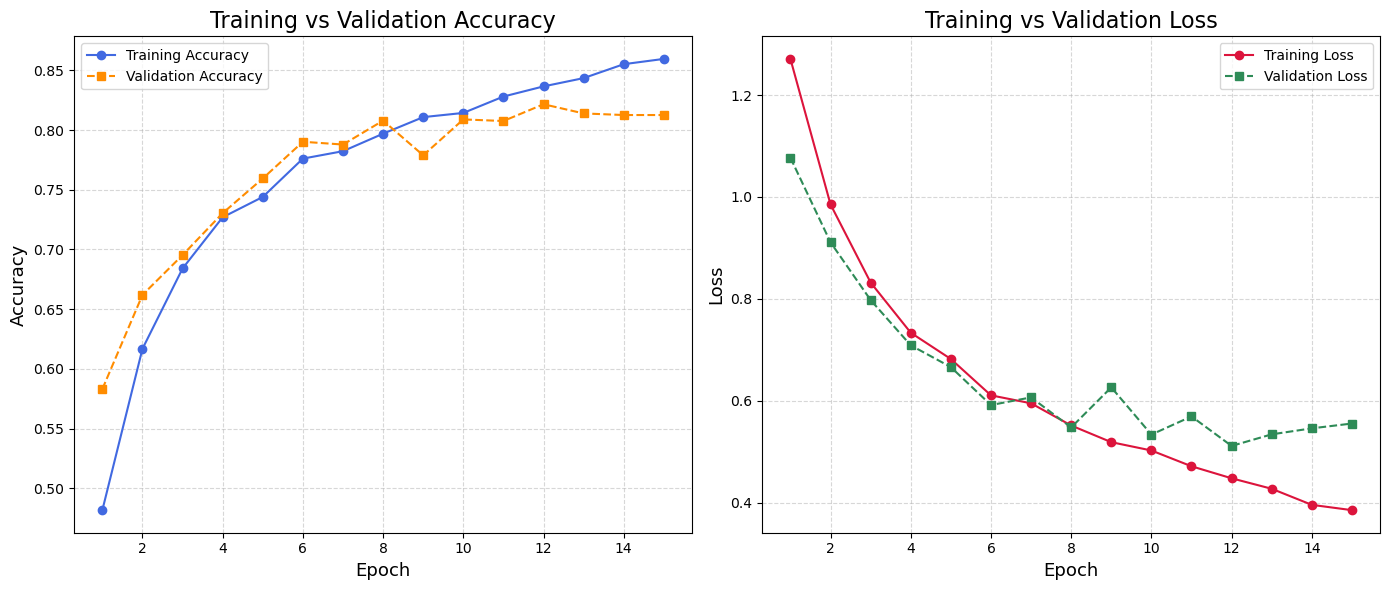

In [81]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(14,6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, marker='o', linestyle='-', color='royalblue', label='Training Accuracy')
    plt.plot(epochs, val_acc, marker='s', linestyle='--', color='darkorange', label='Validation Accuracy')
    plt.title("Training vs Validation Accuracy", fontsize=16)
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, marker='o', linestyle='-', color='crimson', label='Training Loss')
    plt.plot(epochs, val_loss, marker='s', linestyle='--', color='seagreen', label='Validation Loss')
    plt.title("Training vs Validation Loss", fontsize=16)
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Loss', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history)

### Confusion matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


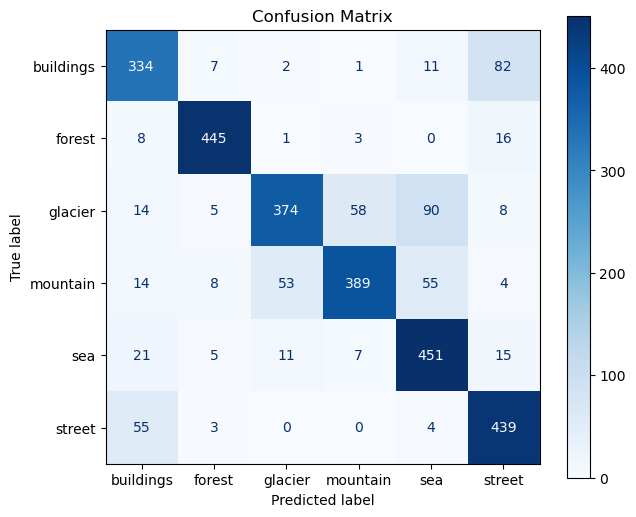

In [95]:
# 1. 获取模型预测结果（预测概率 → 预测类别）
predicted_probs = model.predict(test_images_norm)
predicted_labels = np.argmax(predicted_probs, axis=1)

# 2. 将 One-Hot 编码的真实标签还原为整数形式
true_labels = np.argmax(test_labels, axis=1)

# 3. 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

# 4. 设置类别标签
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# 5. 绘制混淆矩阵
fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Misclassified examples

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


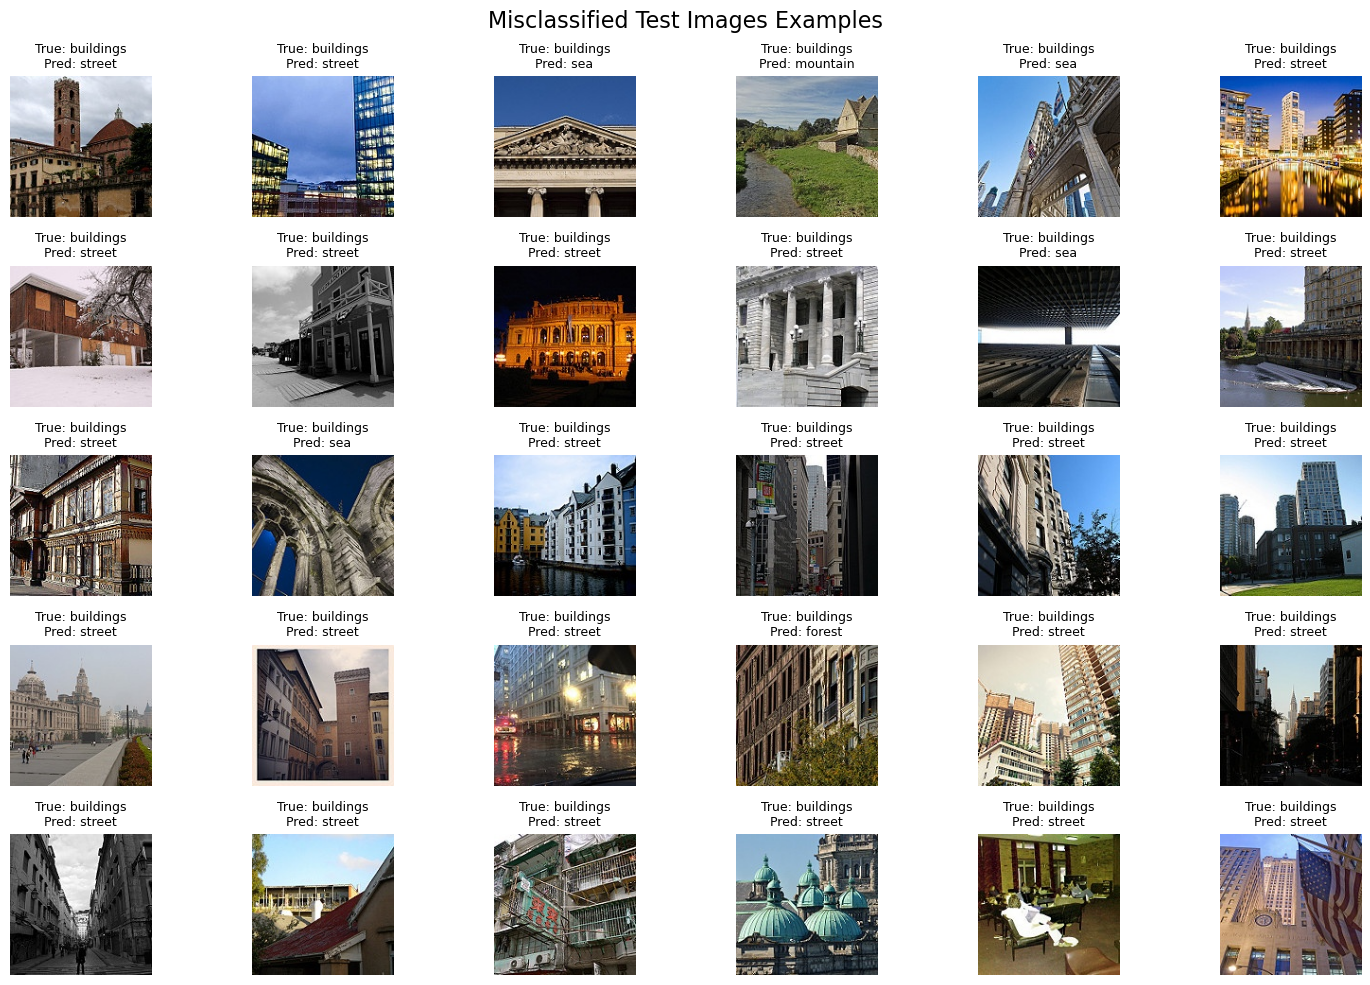

In [111]:
# 1. 找到误分类的索引
predicted_labels = np.argmax(model.predict(test_images_norm), axis=1)

true_labels = np.argmax(test_labels, axis=1)

misclassified_idx = np.where(predicted_labels != true_labels)[0]

# 2. 选出前20个误判样本（如果不足20个会自动取全部）
misclassified_idx = misclassified_idx[:30]

# 3. 类别名称
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# 4. 画图
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx):
    plt.subplot(5, 6, i+1)
    img = test_images[idx]  # 原始图像
    img = (img).astype('uint8')  # ✅ 转为整数格式
    plt.imshow(img)  # 若归一化过，先还原
    plt.axis('off')
    true = class_names[true_labels[idx]]
    pred = class_names[predicted_labels[idx]]
    plt.title(f"True: {true}\nPred: {pred}", fontsize=9)

plt.suptitle("Misclassified Test Images Examples", fontsize=16)
plt.tight_layout()
plt.show()


### Model Saving

In [114]:
model.save("CNN_model.keras")

### Data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1), 
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [24]:
train_labels = to_categorical(train_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True) / 255.0, y))
train_ds = train_ds.shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((test_images / 255.0, test_labels))
val_ds = val_ds.batch(128).prefetch(tf.data.AUTOTUNE)

In [26]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue2.keras', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_ds,  epochs=20, validation_data=(val_ds),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(val_ds, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 934ms/step - accuracy: 0.5436 - loss: 1.7912 - val_accuracy: 0.1674 - val_loss: 4.0578
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 940ms/step - accuracy: 0.2205 - loss: 2.0338 - val_accuracy: 0.1674 - val_loss: 5.4944
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 944ms/step - accuracy: 0.2496 - loss: 1.7430 - val_accuracy: 0.1704 - val_loss: 1.8839
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 946ms/step - accuracy: 0.1425 - loss: 1.7005 - val_accuracy: 0.1674 - val_loss: 2.0028
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 111s 955ms/step - accuracy: 0.0782 - loss: 1.7409 - val_accuracy: 0.1704 - val_loss: 1.7910
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 109s 937ms/step - accuracy: 0.0210 - loss: 1.8436 - val_accuracy: 0.1704 - val_loss: 1.7901
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 947ms/step - accuracy: 0.0280 - loss: 1.8236 - val_accuracy: 0.1704 - val_loss: 1.7900
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 111s 948ms/step - accuracy: 0.0286 -